In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed master dataset
master = pd.read_csv(
    '../data/processed/master_orders.csv',
    parse_dates=['order_purchase_timestamp']
)

# Reference date (1 day after last order date)
REF_DATE = pd.Timestamp('2018-10-18')

# Calculate RFM
rfm = master.groupby('customer_unique_id').agg(
    recency   = ('order_purchase_timestamp',
                 lambda x: (REF_DATE - x.max()).days),
    frequency = ('order_id', 'count'),
    monetary  = ('total_payment', 'sum')
).reset_index()

rfm['monetary'] = rfm['monetary'].round(2)

print(f"Total customers: {len(rfm):,}")
print("\nRFM Summary:")
print(rfm[['recency','frequency','monetary']].describe().round(1))


Total customers: 93,357

RFM Summary:
       recency  frequency  monetary
count  93357.0    93357.0   93357.0
mean     286.5        1.0     165.2
std      152.6        0.2     226.3
min       49.0        1.0       9.6
25%      163.0        1.0      63.1
50%      267.0        1.0     107.8
75%      395.0        1.0     182.6
max      744.0       15.0   13664.1


In [2]:
# Score R (lower recency = better, so reverse labels)
rfm['r_score'] = pd.qcut(
    rfm['recency'],
    q=4,
    labels=[4,3,2,1]
)

# Score F (rank first to handle ties)
rfm['f_score'] = pd.qcut(
    rfm['frequency'].rank(method='first'),
    q=4,
    labels=[1,2,3,4]
)

# Score M
rfm['m_score'] = pd.qcut(
    rfm['monetary'],
    q=4,
    labels=[1,2,3,4]
)

# Convert to int
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

print("Score Distribution:")
print(rfm['rfm_score'].value_counts().sort_index())


Score Distribution:
rfm_score
3      1517
4      4589
5      8964
6     14476
7     17466
8     16928
9     14160
10     8871
11     4594
12     1792
Name: count, dtype: int64


In [3]:
def assign_segment(row):
    r, f, m = row['r_score'], row['f_score'], row['m_score']
    score = r + f + m

    if score >= 11:
        return 'Champions'
    elif score >= 9 and f >= 3:
        return 'Loyal Customers'
    elif score >= 8 and r >= 3:
        return 'Potential Loyalists'
    elif r == 4 and score <= 6:
        return 'New Customers'
    elif r <= 2 and score >= 8:
        return 'At Risk'
    elif r == 1 and score <= 5:
        return 'Lost'
    else:
        return 'Need Attention'

rfm['segment'] = rfm.apply(assign_segment, axis=1)

# Segment summary
seg_summary = rfm.groupby('segment').agg(
    customers   = ('customer_unique_id', 'count'),
    avg_recency = ('recency', 'mean'),
    avg_freq    = ('frequency', 'mean'),
    avg_spend   = ('monetary', 'mean'),
    total_rev   = ('monetary', 'sum')
).round(1).reset_index()

seg_summary['revenue_pct'] = (
    seg_summary['total_rev'] /
    seg_summary['total_rev'].sum() * 100
).round(1)

print(seg_summary.sort_values('customers', ascending=False).to_string(index=False))


            segment  customers  avg_recency  avg_freq  avg_spend  total_rev  revenue_pct
     Need Attention      36414        327.6       1.0      116.7  4248814.3         27.5
    Loyal Customers      17272        233.4       1.1      204.9  3539524.3         23.0
Potential Loyalists      15716        154.0       1.0      200.7  3154494.3         20.5
               Lost       9161        500.6       1.0       72.1   660275.2          4.3
            At Risk       6971        394.8       1.0      227.2  1583771.3         10.3
          Champions       6386        136.9       1.2      340.4  2173668.7         14.1
      New Customers       1437        106.0       1.0       43.1    61913.6          0.4


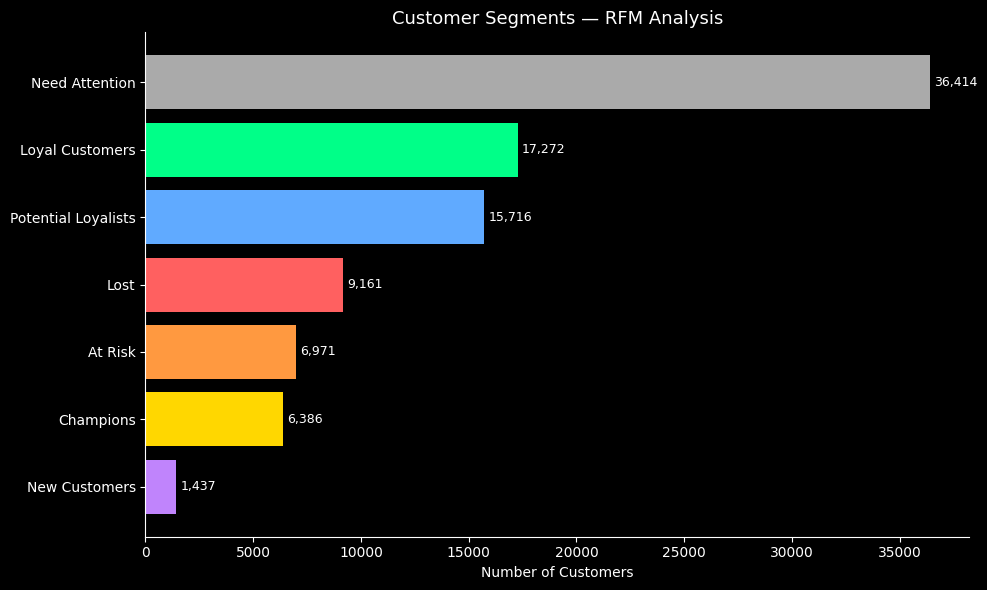

In [4]:
plt.style.use('dark_background')

colors = {
    'Champions': '#ffd700',
    'Loyal Customers': '#00ff88',
    'Potential Loyalists': '#60aaff',
    'New Customers': '#c084fc',
    'At Risk': '#ff9940',
    'Need Attention': '#aaaaaa',
    'Lost': '#ff6060'
}

seg_sorted = seg_summary.sort_values('customers')

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(
    seg_sorted['segment'],
    seg_sorted['customers'],
    color=[colors[s] for s in seg_sorted['segment']]
)

for bar, val in zip(bars, seg_sorted['customers']):
    ax.text(val + 200, bar.get_y() + bar.get_height()/2,
            f'{val:,}', va='center', fontsize=9)

ax.set_title('Customer Segments — RFM Analysis', fontsize=13)
ax.set_xlabel('Number of Customers')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


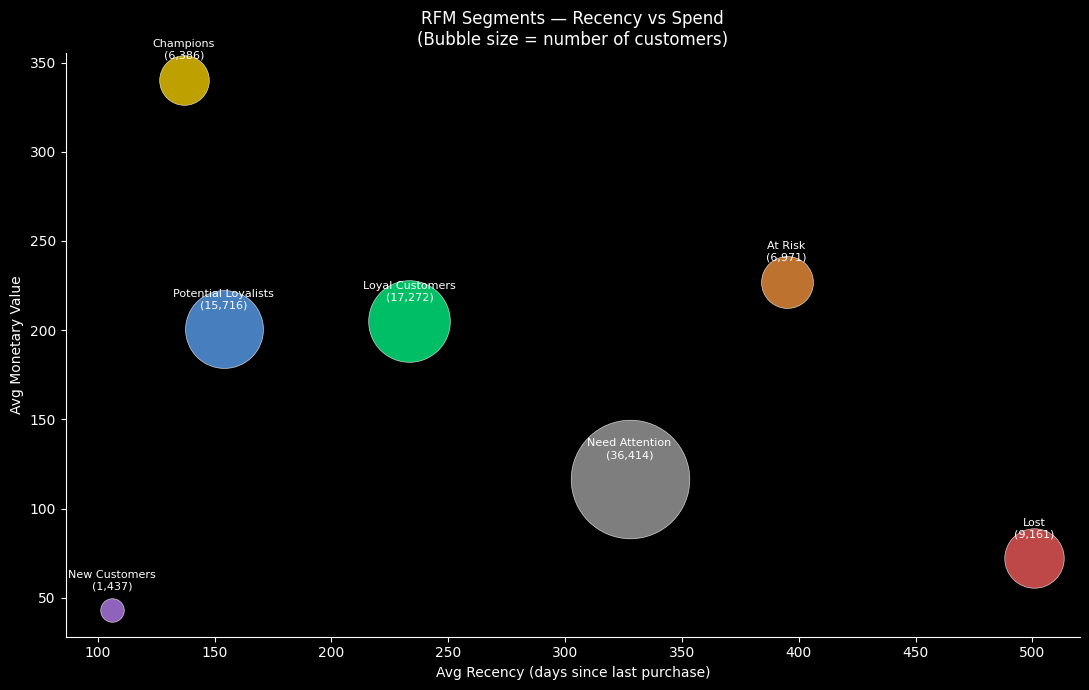

In [5]:
fig, ax = plt.subplots(figsize=(11,7))

for _, row in seg_summary.iterrows():
    ax.scatter(
        row['avg_recency'],
        row['avg_spend'],
        s=row['customers']/5,
        c=colors.get(row['segment'], '#888'),
        alpha=0.75,
        edgecolors='white',
        linewidths=0.5
    )
    
    ax.annotate(
        f"{row['segment']}\n({row['customers']:,})",
        xy=(row['avg_recency'], row['avg_spend']),
        fontsize=8,
        ha='center',
        xytext=(0,15),
        textcoords='offset points'
    )

ax.set_xlabel('Avg Recency (days since last purchase)')
ax.set_ylabel('Avg Monetary Value')
ax.set_title('RFM Segments — Recency vs Spend\n(Bubble size = number of customers)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [6]:
rfm.to_csv('../data/processed/rfm_scores.csv', index=False)

plt.savefig('../docs/rfm_bubble.png', dpi=150, bbox_inches='tight')
print("Saved rfm_scores.csv and bubble chart.")


Saved rfm_scores.csv and bubble chart.


<Figure size 640x480 with 0 Axes>